### Target classifier

In [1]:
from simpletransformers.language_representation import RepresentationModel
from simpletransformers.classification import MultiLabelClassificationModel
from simpletransformers.config.model_args import ModelArgs
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

In [2]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
data = data[data['source']!='SASDG_Hub'] #keep the articles classified by Willem separate as an unseen testing set
data = data.iloc[-1000:,:] # select a small subset of the data (last 1000 rows)

# import target data
target_df = pd.read_csv('Targets.csv', sep=';')

In [3]:
# function to apply model to text
def classify_sdg(text_lst):
    # see GPU avaialability
    cuda_available = torch.cuda.is_available()
    
    # import model from path (this path is the directory with all the model files)
    sdg_model = MultiLabelClassificationModel(
            "xlnet",
            r"C:\Users\gcmar\Desktop\GIT_REPOS\Transformers_simple_wandb_experiments\SASDGHUB\outputs\best_model\\",
            num_labels=17,
            use_cuda=cuda_available,
            )
    predictions, raw_outputs = sdg_model.predict(text_lst)
    return(predictions, raw_outputs)

In [4]:
# function to classify targets
def classify_sdg_target(text_lst, 
                        target_data_path='Targets.csv',
                        run_isomap=True, # run faster for multiple samples otherwise (target_data_path required when this is False) (do not use when only one sample)
                        target_embedding_reduced_path=None, # load a previously calculated and reduced embedding for the targets 'outputs/targets_embedded_reduced_gpt2_2D.csv'
                        isomap_dims = 2,
                        isomap_neigbors = 5, # has to be <= len(text_lst) a.k.a n_samples
                        pre_trained_model_type='gpt2', 
                        pre_trained_model_name='gpt2'):
    
    # see GPU avaialability
    cuda_available = torch.cuda.is_available()

    # define and load model from hugging face
    model_args = ModelArgs(max_seq_length=1024)
    # model import
    model = RepresentationModel(
        pre_trained_model_type,
        pre_trained_model_name, #gpt2 , gpt2-large
        args=model_args,
    )
    
    # classify sdg of text
    sdg_predictions, sdg_raw_outputs = classify_sdg(text_lst)
    # get embeddings of text
    word_embeddings = model.encode_sentences(text_lst, combine_strategy="mean")
    
    
    # ISOMAP
    if run_isomap==True: 
        # reduce isomap_neigbors to fit the number of samples
        n_samples = len(text_lst)
        if n_samples < isomap_neigbors:
            isomap_neigbors = np.max([1,n_samples-1])
            print('Reduced isomap_n_neigbors to: ', isomap_neigbors)

        # reduce dimensions of embeddings to 2 (can be reduced to higher dimensions)
        isomap = Isomap(n_components=isomap_dims, n_neighbors=isomap_neigbors-1) # input is an array with samples x features
        word_embeddings_transformed = isomap.fit_transform(word_embeddings)

        if target_embedding_reduced_path == None:
            # load pre-calculated embeddings
            target_df = pd.read_csv(target_data_path, sep=';')
            # get sentence list from target data
            target_sentence_list = target_df['text'].tolist()
            # get embeddings of targets
            target_embeddings = model.encode_sentences(target_sentence_list, combine_strategy="mean")
            target_embeddings_transformed = isomap.fit_transform(target_embeddings)
            # add labels to reduced embeddings
            target_trans_df = pd.DataFrame(word_embeddings_transformed)
            target_trans_df['target'] = target_df['target']
            target_trans_df['sdg'] = target_df['sdg']
            target_trans_df.to_csv('outputs/targets_embedded_reduced_'+pre_trained_model_name+'_'+str(isomap_dims)+'D.csv', index=False)
            
            # define source and target for KNN
            Y = target_trans_df
            X = pd.DataFrame(word_embeddings_transformed)
            idx_ar = np.array(range(0,17))
            sdg_label_lst = []
            for row in (np.array(sdg_predictions)==1):
                sdg_label_lst.append(idx_ar[row])
            X['sdg'] = sdg_label_lst
            sdg_prob_lst = []
            for row in sdg_raw_outputs:
                sdg_prob_lst.append(row)
            X['sdg_probability'] = sdg_prob_lst
            
        else:
            # import reduced embedding of targets
            target_trans_df = pd.read_csv(target_embedding_reduced_path, sep=',')
            
            # define source and target for KNN
            Y = target_trans_df
            X = pd.DataFrame(word_embeddings_transformed)
            idx_ar = np.array(range(0,17))
            sdg_label_lst = []
            for row in (np.array(sdg_predictions)==1):
                sdg_label_lst.append(idx_ar[row])
            X['sdg'] = sdg_label_lst
            sdg_prob_lst = []
            for row in sdg_raw_outputs:
                sdg_prob_lst.append(row)
            X['sdg_probability'] = sdg_prob_lst

        # plot embeddings if they are 2D
        if isomap_dims ==2:
            trans_df = pd.DataFrame(word_embeddings_transformed)
            trans_df['target'] = target_df['target']
            trans_df['sdg'] = target_df['sdg']
            trans_df.plot.scatter(0,1,c='sdg', colormap='viridis') # colour by sdg
            plt.show()
    
    else:
        # load pre-calculated embeddings
        target_df = pd.read_csv(target_data_path, sep=';')
        # get sentence list from target data
        target_sentence_list = target_df['text'].tolist()
        # get embeddings of targets
        target_embeddings = model.encode_sentences(target_sentence_list, combine_strategy="mean")
        
        # define source and target for KNN
        Y = pd.DataFrame(target_embeddings)
        Y['target'] = target_df['target']
        Y['sdg'] = target_df['sdg']
        X = pd.DataFrame(word_embeddings)
        idx_ar = np.array(range(0,17))
        sdg_label_lst = []
        for row in (np.array(sdg_predictions)==1):
            sdg_label_lst.append(idx_ar[row])
        X['sdg'] = sdg_label_lst
        sdg_prob_lst = []
        for row in sdg_raw_outputs:
            sdg_prob_lst.append(row)
        X['sdg_probability'] = sdg_prob_lst
    
    
    # Filter by SDG classification on X
    # apply knn on two dataframes
    

    return X, Y

Some weights of the model checkpoint at gpt2 were not used when initializing GPT2ForTextRepresentation: ['h.11.attn.c_attn.bias', 'h.11.attn.c_attn.weight', 'h.11.mlp.c_fc.weight', 'h.10.attn.c_proj.weight', 'h.11.ln_2.weight', 'h.10.mlp.c_fc.weight', 'h.1.ln_2.weight', 'h.1.attn.bias', 'h.3.attn.c_proj.bias', 'h.2.attn.c_attn.bias', 'h.2.mlp.c_fc.weight', 'h.2.ln_2.bias', 'h.0.ln_2.bias', 'h.11.attn.c_proj.bias', 'h.8.attn.c_proj.bias', 'h.3.mlp.c_proj.bias', 'h.8.mlp.c_proj.bias', 'h.4.ln_2.bias', 'h.6.ln_1.bias', 'h.5.ln_1.weight', 'h.8.ln_1.weight', 'h.3.mlp.c_fc.bias', 'h.2.attn.bias', 'h.3.mlp.c_proj.weight', 'h.7.attn.c_attn.bias', 'h.3.mlp.c_fc.weight', 'h.2.mlp.c_proj.bias', 'h.7.mlp.c_proj.bias', 'h.8.ln_2.weight', 'h.0.ln_2.weight', 'wpe.weight', 'h.3.ln_1.weight', 'h.4.attn.bias', 'h.8.mlp.c_proj.weight', 'h.9.ln_2.weight', 'h.7.ln_1.bias', 'h.6.attn.c_attn.bias', 'h.1.attn.c_attn.weight', 'h.9.mlp.c_fc.bias', 'h.10.mlp.c_proj.weight', 'h.1.mlp.c_proj.weight', 'h.5.attn.c_a

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

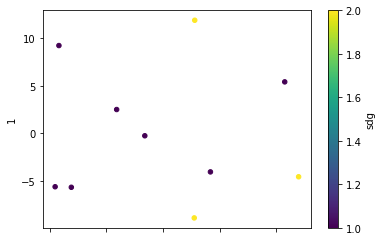

In [5]:
a, b= classify_sdg_target(data.iloc[-10:,:]['abstract'].tolist(), run_isomap=True)

In [6]:
a

,0,1,sdg,sdg_probability
0,10.744605,5.404824,"[0, 3, 7, 9, 16]","[0.12408998608589172, 0.05647684633731842, 0.0..."
1,-9.515295,-5.604776,"[3, 6, 7, 9, 16]","[0.07849065959453583, 0.051520802080631256, 0...."
2,-8.085702,-5.660842,"[0, 3, 4, 7, 9, 15, 16]","[0.1639489233493805, 0.08686479181051254, 0.08..."
3,-9.180405,9.218314,"[5, 6, 7, 8, 10, 16]","[0.06458315253257751, 0.04803938418626785, 0.0..."
4,-1.601232,-0.253775,"[5, 6, 7, 8, 10, 11, 12, 13, 14, 16]","[0.0433623269200325, 0.07563838362693787, 0.08..."
5,-4.085216,2.502656,"[5, 6, 8, 10, 11, 12, 16]","[0.04861505702137947, 0.07050523161888123, 0.0..."
6,4.188988,-4.045839,"[1, 2, 5, 6, 8, 11, 12, 13, 14, 16]","[0.04943974316120148, 0.12201870232820511, 0.1..."
7,2.803382,11.874653,"[1, 2, 5, 6, 8, 10, 11, 12, 13, 14, 16]","[0.07510310411453247, 0.21487849950790405, 0.1..."
8,11.970259,-4.558487,"[3, 4, 7, 9, 15, 16]","[0.09540661424398422, 0.05669081583619118, 0.0..."
9,2.760615,-8.876729,"[0, 3, 6, 7, 9, 15, 16]","[0.119785837829113, 0.04727477207779884, 0.070..."


In [7]:
b

,0,1,target,sdg
0,10.744605,5.404824,1.1,1
1,-9.515295,-5.604776,1.2,1
2,-8.085702,-5.660842,1.3,1
3,-9.180405,9.218314,1.4,1
4,-1.601232,-0.253775,1.5,1
5,-4.085216,2.502656,1.a,1
6,4.188988,-4.045839,1.b,1
7,2.803382,11.874653,2.1,2
8,11.970259,-4.558487,2.2,2
9,2.760615,-8.876729,2.3,2


In [8]:
# evaluate performance to adjust parameters with a sweep on wandb

In [ ]:
# modify function to be used for testing both sdg and target classification